In [1]:
# Read VOCAB from the CSV file
import pandas as pd
#VOCAB = pd.read_csv('VOCAB.csv', index_col=0)  # Use index_col=0 to read the first column as index
CORPUS = pd.read_csv('CORPUS.csv')  # Use index_col=0 to read the first column as index


In [2]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly.express as px


In [3]:
import gensim

In [4]:
# Specify the columns to be used as indexes
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

# Set the specified columns as the multi-index
CORPUS = CORPUS.set_index(OHCO)

# Display the first few rows to verify
print(CORPUS.head())


                                             token_str term_str pos pos_group
book_id chap_num para_num sent_num token_num                                 
1       1.0      0        0        0          _CHAPTER  chapter  NN        NN
                                   1                I_        i  NN        NN
                 1        0        0               THE      the  DT        DT
                                   1            OBJECT   object  NN        NN
                                   2                OF       of  IN        IN


In [5]:
CORPUS

token_str term_str pos pos_group
book_id chap_num para_num sent_num token_num                                 
1       1.0      0        0        0          _CHAPTER  chapter  NN        NN
                                   1                I_        i  NN        NN
                 1        0        0               THE      the  DT        DT
                                   1            OBJECT   object  NN        NN
                                   2                OF       of  IN        IN
...                                                ...      ...  ..       ...
4       33.0     147      0        34               to       to  TO        TO
                                   35             hear     hear  NN        NN
                                   36            about    about  IN        IN
                                   37              new      new  JJ        JJ
                                   38          eBooks.   ebooks  NN        NN

[784641 rows x 4 columns]

In [6]:
# Assume CORPUS is a DataFrame already loaded into memory
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
BAG = OHCO[:3]


In [7]:
# Set book_id, chap_num, para_num, sent_num, and token_num as indexes if not already set
if not CORPUS.index.names == OHCO:
    CORPUS = CORPUS.set_index(OHCO)

# Create the TOKENS DataFrame from CORPUS including pos_group
TOKENS = CORPUS[['term_str', 'pos_group']].reset_index()

# Display the first few rows to verify
TOKENS.head()


book_id  chap_num  para_num  sent_num  token_num term_str pos_group
0        1       1.0         0         0          0  chapter        NN
1        1       1.0         0         0          1        i        NN
2        1       1.0         1         0          0      the        DT
3        1       1.0         1         0          1   object        NN
4        1       1.0         1         0          2       of        IN

In [8]:
TOKENS2 = TOKENS[~TOKENS['pos_group'].str.match(r'NNPS?')]

# Display the first few rows to verify
TOKENS2.head()


book_id  chap_num  para_num  sent_num  token_num term_str pos_group
0        1       1.0         0         0          0  chapter        NN
1        1       1.0         0         0          1        i        NN
2        1       1.0         1         0          0      the        DT
3        1       1.0         1         0          1   object        NN
4        1       1.0         1         0          2       of        IN

In [9]:
class W2VExplorer:
    
    w2v_min_count:int = 10
    w2v_workers:int = 4
    w2v_size:int = 256
    w2v_window:int = 2
    tsne_perplexity:int = 40
    tsne_n_components:int = 2
    tsne_init:str = 'pca'
    tsne_n_iter:int = 2500
    tsne_random_state:int = 23
        
    
    def __init__(self, tokens, bag):
        self.TOKENS:pd.DataFrame = tokens
        self.BAG = bag
        
    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self
        
    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """Run word2vec again the docs"""
        self.model = word2vec.Word2Vec(self.DOCS, 
                                 vector_size = self.w2v_size, 
                                 window = self.w2v_window, 
                                 min_count = self.w2v_min_count, 
                                 workers = self.w2v_workers)

    def _get_tsne_coords(self):
        # self.coords = pd.DataFrame(index=range(len(self.model.wv.vocab))) # Gensim 3
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        # self.coords['label'] = [w for w in self.model.wv.vocab] # Gensim 3
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity = 40, 
                               n_components = self.tsne_n_components, 
                               init = self.tsne_init, 
                               n_iter = self.tsne_n_iter, 
                               random_state = self.tsne_random_state)
        # self.tsne_values = self.tsne_model.fit_transform(self.coords['vector'].tolist())
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:,0]
        self.coords['y'] = self.tsne_values[:,1]
        
    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000)\
            .update_traces(mode='text').show()
        
    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim'])        


In [10]:
new = W2VExplorer(TOKENS2, BAG)
new.w2v_min_count = 50
new.generate_model()


Bag: para_num
Getting DOCS
Getting MODEL
Getting tSNE Coords
✓


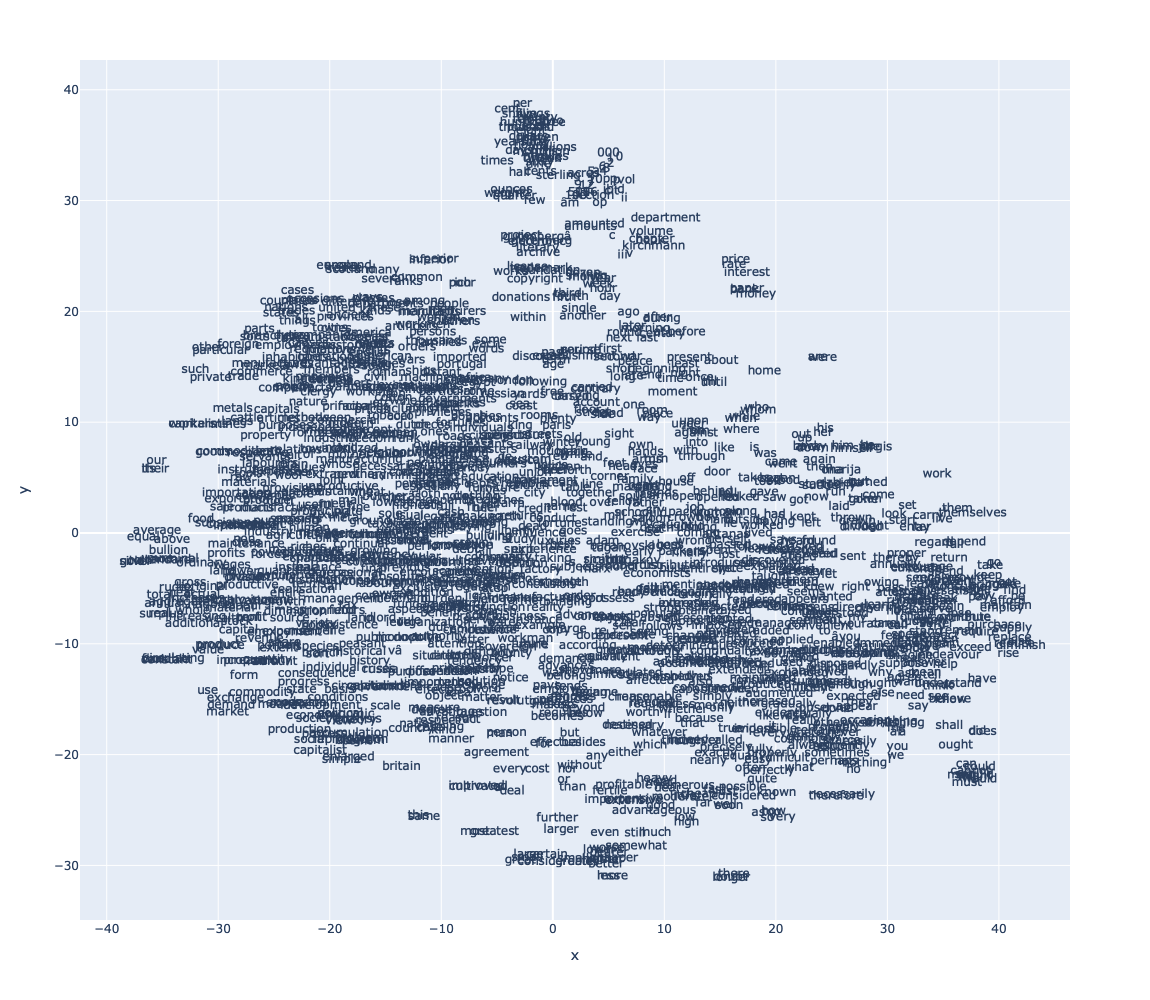

In [39]:
new.plot_tsne()

In [13]:
# Extract the Word2Vec vectors and create the VOCAB_W2V table
vocab_terms = TOKENS2['term_str'].unique()
vectors = []
terms_in_model = new.model.wv.key_to_index

for term in vocab_terms:
    if term in terms_in_model:
        vectors.append(new.model.wv.get_vector(term))
    else:
        vectors.append([None] * new.model.vector_size)

VOCAB_W2V = pd.DataFrame(vectors, index=vocab_terms)

# Print or inspect the resulting DataFrame


In [14]:
# Assuming VOCAB_W2V is already defined
VOCAB_W2V = VOCAB_W2V.dropna()

# To verify the rows with NaNs have been removed
VOCAB_W2V


0         1         2         3         4         5    \
chapter    -0.194536 -0.071204 -0.029247 -0.120198  0.267227  0.024530   
i           0.300066 -0.132026 -0.229891 -0.575825  0.750053  0.167520   
the         0.139933 -0.594325 -0.007206  0.552548 -0.133372 -0.403326   
object     -0.165897 -0.077360 -0.156608 -0.148771  0.373950  0.231629   
of         -0.274603  0.036161 -0.606899 -0.308364 -0.115547 -0.235718   
...              ...       ...       ...       ...       ...       ...   
artificers -0.146526 -0.234980  0.197025  0.063070  0.133833  0.024322   
parish     -0.265116 -0.271350  0.056741 -0.114753  0.490739  0.239167   
bounty     -0.047584 -0.195858 -0.048550 -0.242579  0.372980  0.249334   
bounties   -0.051012 -0.265111  0.080477  0.020531  0.200510  0.116743   
portugal   -0.115459 -0.227661  0.103089  0.044993  0.097468  0.091639   

                 6         7         8         9    ...       246       247  \
chapter     0.077467  0.052747  0.005459 -0.025132  ...  0.179436  0.106161   
i           0.305111 -0.377625  0.015576 -0.588091  ...  0.504295  0.232708   
the        -0.061588  0.616565 -0.101802  0.131738  ...  0.231678  0.148484   
object      0.067913  0.085119  0.025680  0.062108  ...  0.198591  0.237322   
of          0.406036  0.424004 -0.035689  0.766221  ... -0.134035 -0.242302   
...              ...       ...       ...       ...  ...       ...       ...   
artificers -0.042661  0.126882 -0.107108  0.234743  ... -0.019972  0.142262   
parish      0.112739  0.134509  0.029296  0.091677  ... -0.048435  0.168921   
bounty      0.197838  0.171567 -0.024899 -0.007834  ...  0.099048  0.244610   
bounties    0.130178  0.131979 -0.025519  0.120059  ...  0.161432  0.239036   
portugal    0.081566  0.113475 -0.061978  0.108610  ...  0.074394  0.098858   

                 248       249       250       251       252       253  \
chapter    -0.040695  0.080946 -0.011635  0.250593 -0.177618 -0.146316   
i          -0.592530 -0.151551  0.063825  0.556146 -0.741900  0.040329   
the        -0.434378  0.245921  0.430648 -0.182203  0.071906 -0.191234   
object     -0.084816  0.306587  0.055993 -0.045301 -0.012770 -0.026717   
of         -0.383859  0.488379  0.152947 -0.159091 -0.276021 -0.210815   
...              ...       ...       ...       ...       ...       ...   
artificers -0.142446  0.129084  0.014943  0.133192 -0.233048 -0.014557   
parish      0.002542  0.232708 -0.040978  0.096565 -0.191715 -0.074530   
bounty      0.061948  0.280714 -0.146276  0.126711 -0.085388 -0.013231   
bounties   -0.049698  0.171284 -0.062962  0.138747 -0.098353 -0.029205   
portugal   -0.012107  0.203145  0.007424  0.102776 -0.170573 -0.083656   

                 254       255  
chapter    -0.306710 -0.111686  
i           0.072090 -0.213903  
the        -0.465566 -0.165764  
object     -0.421262 -0.121132  
of         -0.110463 -0.155578  
...              ...       ...  
artificers -0.313459 -0.157136  
parish     -0.203629 -0.060162  
bounty     -0.262108 -0.071771  
bounties   -0.350913 -0.042511  
portugal   -0.285971 -0.135439  

[1483 rows x 256 columns]

In [15]:
VOCAB_W2V.to_csv('VOCAB_W2V.csv', index=False)


In [16]:
VOCAB_W2V

0         1         2         3         4         5    \
chapter    -0.194536 -0.071204 -0.029247 -0.120198  0.267227  0.024530   
i           0.300066 -0.132026 -0.229891 -0.575825  0.750053  0.167520   
the         0.139933 -0.594325 -0.007206  0.552548 -0.133372 -0.403326   
object     -0.165897 -0.077360 -0.156608 -0.148771  0.373950  0.231629   
of         -0.274603  0.036161 -0.606899 -0.308364 -0.115547 -0.235718   
...              ...       ...       ...       ...       ...       ...   
artificers -0.146526 -0.234980  0.197025  0.063070  0.133833  0.024322   
parish     -0.265116 -0.271350  0.056741 -0.114753  0.490739  0.239167   
bounty     -0.047584 -0.195858 -0.048550 -0.242579  0.372980  0.249334   
bounties   -0.051012 -0.265111  0.080477  0.020531  0.200510  0.116743   
portugal   -0.115459 -0.227661  0.103089  0.044993  0.097468  0.091639   

                 6         7         8         9    ...       246       247  \
chapter     0.077467  0.052747  0.005459 -0.025132  ...  0.179436  0.106161   
i           0.305111 -0.377625  0.015576 -0.588091  ...  0.504295  0.232708   
the        -0.061588  0.616565 -0.101802  0.131738  ...  0.231678  0.148484   
object      0.067913  0.085119  0.025680  0.062108  ...  0.198591  0.237322   
of          0.406036  0.424004 -0.035689  0.766221  ... -0.134035 -0.242302   
...              ...       ...       ...       ...  ...       ...       ...   
artificers -0.042661  0.126882 -0.107108  0.234743  ... -0.019972  0.142262   
parish      0.112739  0.134509  0.029296  0.091677  ... -0.048435  0.168921   
bounty      0.197838  0.171567 -0.024899 -0.007834  ...  0.099048  0.244610   
bounties    0.130178  0.131979 -0.025519  0.120059  ...  0.161432  0.239036   
portugal    0.081566  0.113475 -0.061978  0.108610  ...  0.074394  0.098858   

                 248       249       250       251       252       253  \
chapter    -0.040695  0.080946 -0.011635  0.250593 -0.177618 -0.146316   
i          -0.592530 -0.151551  0.063825  0.556146 -0.741900  0.040329   
the        -0.434378  0.245921  0.430648 -0.182203  0.071906 -0.191234   
object     -0.084816  0.306587  0.055993 -0.045301 -0.012770 -0.026717   
of         -0.383859  0.488379  0.152947 -0.159091 -0.276021 -0.210815   
...              ...       ...       ...       ...       ...       ...   
artificers -0.142446  0.129084  0.014943  0.133192 -0.233048 -0.014557   
parish      0.002542  0.232708 -0.040978  0.096565 -0.191715 -0.074530   
bounty      0.061948  0.280714 -0.146276  0.126711 -0.085388 -0.013231   
bounties   -0.049698  0.171284 -0.062962  0.138747 -0.098353 -0.029205   
portugal   -0.012107  0.203145  0.007424  0.102776 -0.170573 -0.083656   

                 254       255  
chapter    -0.306710 -0.111686  
i           0.072090 -0.213903  
the        -0.465566 -0.165764  
object     -0.421262 -0.121132  
of         -0.110463 -0.155578  
...              ...       ...  
artificers -0.313459 -0.157136  
parish     -0.203629 -0.060162  
bounty     -0.262108 -0.071771  
bounties   -0.350913 -0.042511  
portugal   -0.285971 -0.135439  

[1483 rows x 256 columns]

In [17]:
from numpy.linalg import eigh

def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF


In [18]:
import pandas as pd

# Load the CSVs into DataFrames
LOADINGS_TFIDF_L2 = pd.read_csv('LOADINGS_TFIDF_L2.csv')
DCM_TFIDF_L2 = pd.read_csv('DCM_TFIDF_L2.csv')
COMPINF_TFIDF_L2 = pd.read_csv('COMPINF_TFIDF_L2.csv')


In [21]:
DCM_TFIDF_L2 = pd.read_csv('DCM_TFIDF_L2.csv', index=)


book_id  chap_num         0         1         2         3         4  \
0          1       1.0  0.345078  0.435567 -0.192427  0.030735 -0.139981   
1          1       2.0  0.373752  0.252568 -0.238567  0.063287 -0.274043   
2          1       3.0  0.354566  0.307670 -0.139905  0.089704 -0.189170   
3          1       4.0  0.384948  0.431416 -0.210350  0.034056 -0.284535   
4          1       5.0  0.347850  0.460052 -0.250685 -0.024006 -0.191547   
..       ...       ...       ...       ...       ...       ...       ...   
107        4      29.0  0.143187 -0.312187 -0.086747 -0.017335  0.210370   
108        4      30.0  0.244559 -0.396943 -0.149784  0.080202 -0.106104   
109        4      31.0  0.181260 -0.407392  0.027029  0.064032 -0.103648   
110        4      32.0  0.181994 -0.359866 -0.077724 -0.044855 -0.032252   
111        4      33.0  0.160279 -0.265729  0.085452 -0.761205 -0.095322   

            5         6         7         8         9  
0   -0.085803  0.091317  0.021575  0.026080 -0.055044  
1   -0.011133 -0.152493 -0.022153 -0.001581  0.054176  
2   -0.021333 -0.154608 -0.012096  0.039497 -0.075060  
3   -0.154098  0.026832  0.015579 -0.022673 -0.014736  
4   -0.248621  0.121433  0.050020 -0.066438 -0.067159  
..        ...       ...       ...       ...       ...  
107  0.023719  0.298729 -0.005845 -0.330277 -0.146664  
108  0.139668  0.075545  0.006714 -0.119754 -0.008065  
109  0.065931  0.057121  0.004246  0.016235  0.149776  
110  0.074103  0.070729 -0.018058 -0.028731  0.150877  
111  0.052387 -0.003702 -0.073717  0.016001  0.059547  

[112 rows x 12 columns]

In [22]:
OHCO = ['book_id', 'chap_num']

DCM_TFIDF_L2 = DCM_TFIDF_L2.set_index(OHCO)

DCM_TFIDF_L2

0         1         2         3         4         5  \
book_id chap_num                                                               
1       1.0       0.345078  0.435567 -0.192427  0.030735 -0.139981 -0.085803   
        2.0       0.373752  0.252568 -0.238567  0.063287 -0.274043 -0.011133   
        3.0       0.354566  0.307670 -0.139905  0.089704 -0.189170 -0.021333   
        4.0       0.384948  0.431416 -0.210350  0.034056 -0.284535 -0.154098   
        5.0       0.347850  0.460052 -0.250685 -0.024006 -0.191547 -0.248621   
...                    ...       ...       ...       ...       ...       ...   
4       29.0      0.143187 -0.312187 -0.086747 -0.017335  0.210370  0.023719   
        30.0      0.244559 -0.396943 -0.149784  0.080202 -0.106104  0.139668   
        31.0      0.181260 -0.407392  0.027029  0.064032 -0.103648  0.065931   
        32.0      0.181994 -0.359866 -0.077724 -0.044855 -0.032252  0.074103   
        33.0      0.160279 -0.265729  0.085452 -0.761205 -0.095322  0.052387   

                         6         7         8         9  
book_id chap_num                                          
1       1.0       0.091317  0.021575  0.026080 -0.055044  
        2.0      -0.152493 -0.022153 -0.001581  0.054176  
        3.0      -0.154608 -0.012096  0.039497 -0.075060  
        4.0       0.026832  0.015579 -0.022673 -0.014736  
        5.0       0.121433  0.050020 -0.066438 -0.067159  
...                    ...       ...       ...       ...  
4       29.0      0.298729 -0.005845 -0.330277 -0.146664  
        30.0      0.075545  0.006714 -0.119754 -0.008065  
        31.0      0.057121  0.004246  0.016235  0.149776  
        32.0      0.070729 -0.018058 -0.028731  0.150877  
        33.0     -0.003702 -0.073717  0.016001  0.059547  

[112 rows x 10 columns]

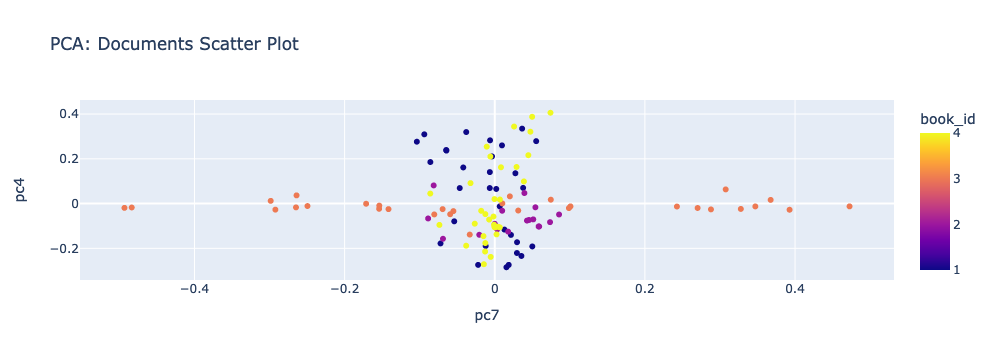

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import pandas as pd

# Extract principal component scores and metadata
pc1 = DCM_TFIDF_L2.iloc[:, 7]
pc2 = DCM_TFIDF_L2.iloc[:, 4]
metadata = DCM_TFIDF_L2.index.get_level_values('book_id')  # Adjust based on your actual metadata

# Create DataFrame for plotly
df_plot = DCM_TFIDF_L2.reset_index()
df_plot['pc7'] = pc1.values
df_plot['pc4'] = pc2.values

# Create interactive scatter plot using Plotly
fig = px.scatter(df_plot, x='pc7', y='pc4', color='book_id',
                 hover_data=['chap_num'],  # Add more hover info if needed
                 title='PCA: Documents Scatter Plot')
fig.show()


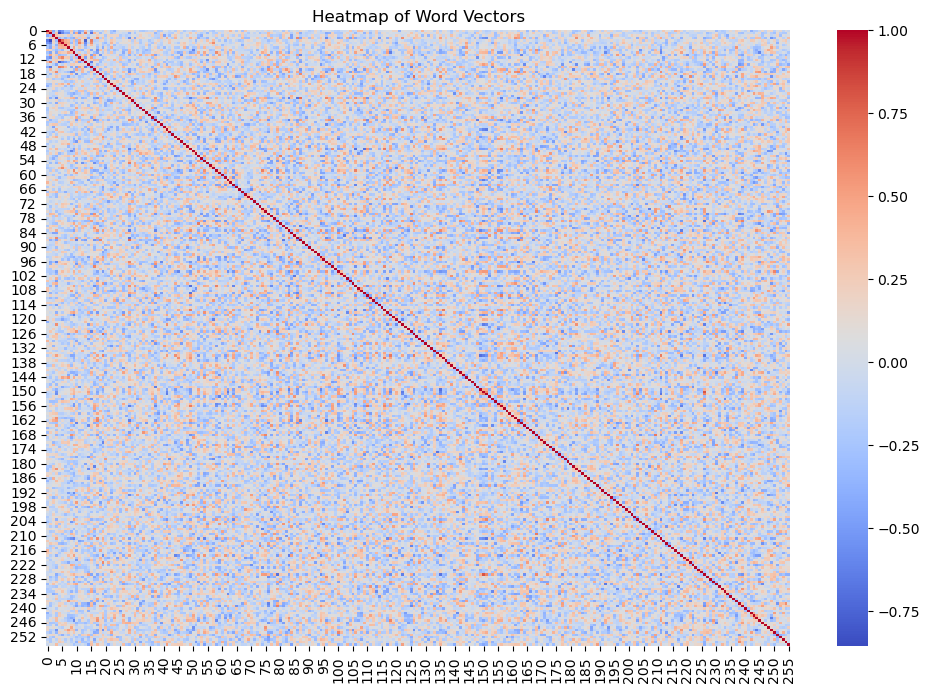

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_word_vector_heatmap(vocab_w2v):
    plt.figure(figsize=(12, 8))
    sns.heatmap(vocab_w2v.corr(), cmap="coolwarm", annot=False)
    plt.title("Heatmap of Word Vectors")
    plt.show()

# Example usage:
plot_word_vector_heatmap(VOCAB_W2V)


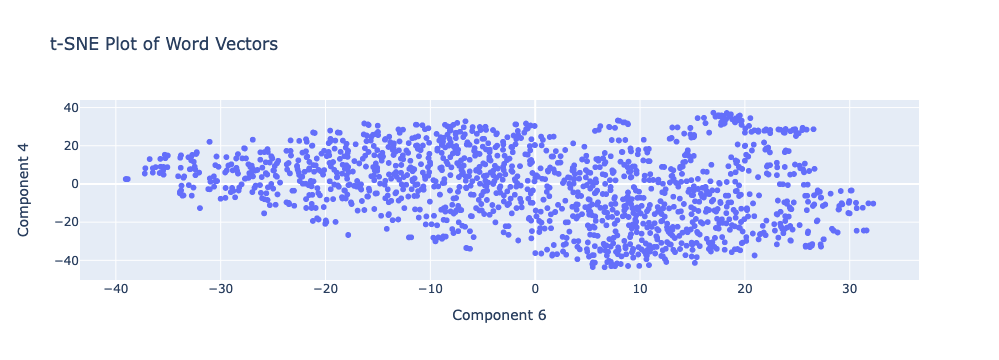

In [58]:
import plotly.express as px
from sklearn.manifold import TSNE
import pandas as pd

def plot_tsne_word_vectors(vocab_w2v):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vocab_w2v.values)

    tsne_df = pd.DataFrame(reduced_vectors, columns=["Component 6", "Component 4"])
    tsne_df["Word"] = vocab_w2v.index

    fig = px.scatter(
        tsne_df,
        x="Component 6",
        y="Component 4",
        hover_name="Word",
        title="t-SNE Plot of Word Vectors",
    )
    fig.show()

# Example usage:
plot_tsne_word_vectors(VOCAB_W2V)


In [60]:
BOW_SENT = pd.read_csv("BOW_SENT.csv")
BOW_SENT

term_str  book_id  chap_num  n_x     tfidf    n_y         p  \
0           achieve        1       1.0    1  0.007247   11.0  0.000014   
1           advance        1       1.0    1  0.003459   76.0  0.000097   
2           anarchy        1       1.0    1  0.006975   17.0  0.000022   
3      antagonistic        1       1.0    1  0.011304    4.0  0.000005   
4           assured        1       1.0    1  0.004810   40.0  0.000051   
...             ...      ...       ...  ...       ...    ...       ...   
15776         weary        4      33.0    1  0.002150   11.0  0.000014   
15777        weight        4      33.0    7  0.009714  136.0  0.000173   
15778         white        4      33.0    2  0.001935   81.0  0.000103   
15779          word        4      33.0    1  0.000622  100.0  0.000127   
15780         worse        4      33.0    3  0.002833   61.0  0.000078   

               i max_pos max_pos_group  ... nrc_anticipation  nrc_disgust  \
0      16.122242      NN            NN  ...              0.0          0.0   
1      13.333746      NN            NN  ...              1.0          0.0   
2      15.494210      NN            NN  ...              0.0          0.0   
3      17.581673      JJ            JJ  ...              0.0          1.0   
4      14.259745     VBN            VB  ...              0.0          0.0   
...          ...     ...           ...  ...              ...          ...   
15776  16.122242      JJ            JJ  ...              0.0          0.0   
15777  12.494210      NN            NN  ...              1.0          1.0   
15778  13.241823      JJ            JJ  ...              1.0          0.0   
15779  12.937817      NN            NN  ...              0.0          0.0   
15780  13.650936     JJR            JJ  ...              0.0          0.0   

       nrc_fear  nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
0           0.0      1.0           0.0           1.0          0.0   
1           1.0      1.0           0.0           1.0          0.0   
2           1.0      0.0           1.0           0.0          0.0   
3           0.0      0.0           1.0           0.0          0.0   
4           0.0      0.0           0.0           1.0          0.0   
...         ...      ...           ...           ...          ...   
15776       0.0      0.0           1.0           0.0          1.0   
15777       1.0      1.0           1.0           1.0          1.0   
15778       0.0      1.0           0.0           1.0          0.0   
15779       0.0      0.0           0.0           1.0          0.0   
15780       1.0      0.0           1.0           0.0          1.0   

       nrc_surprise  nrc_trust  nrc_sentiment  
0               0.0        1.0            1.0  
1               1.0        0.0            1.0  
2               0.0        0.0           -1.0  
3               0.0        0.0           -1.0  
4               0.0        1.0            1.0  
...             ...        ...            ...  
15776           0.0        0.0           -1.0  
15777           1.0        1.0            0.0  
15778           0.0        1.0            1.0  
15779           0.0        1.0            1.0  
15780           0.0        0.0           -1.0  

[15781 rows x 24 columns]

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

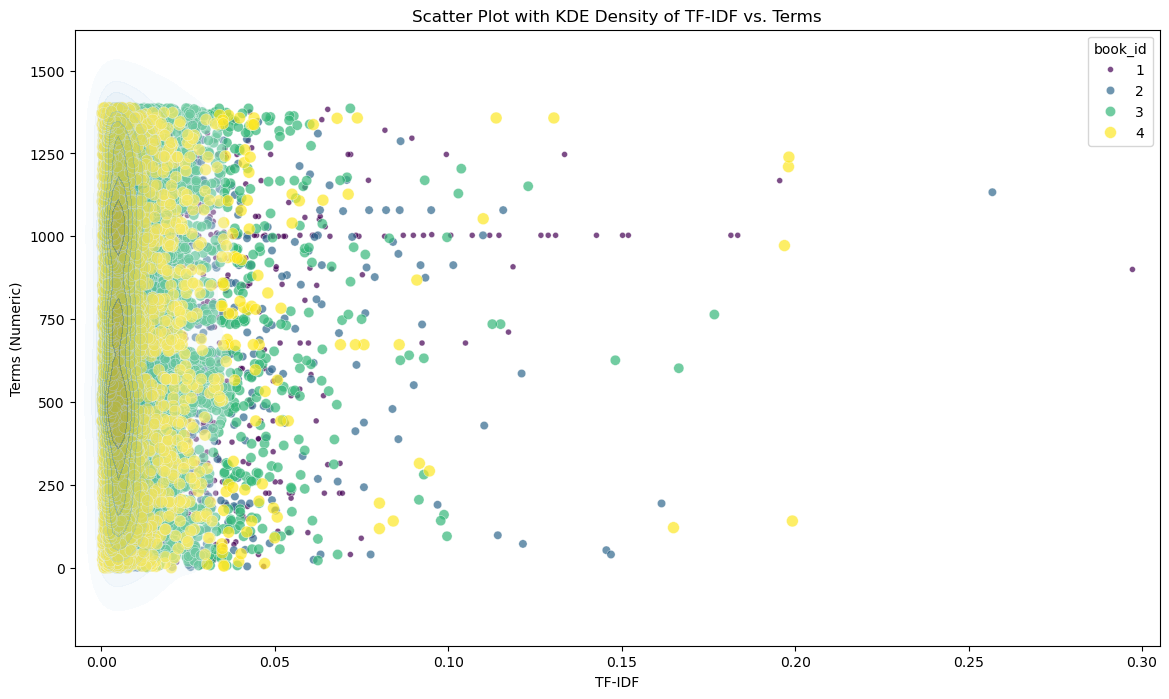

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Prepare data for the plot
bow_sent_plot = BOW_SENT.copy()

# Convert term_str to numeric using LabelEncoder for easy plotting
le = LabelEncoder()
bow_sent_plot['term_str_num'] = le.fit_transform(bow_sent_plot['term_str'])

# Scatter plot with KDE density
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='tfidf', 
    y='term_str_num', 
    size='book_id', 
    hue='book_id',
    data=bow_sent_plot, 
    palette='viridis', 
    alpha=0.7
)
sns.kdeplot(
    x='tfidf', 
    y='term_str_num',
    data=bow_sent_plot, 
    cmap='Blues', 
    fill=True, 
    alpha=0.3
)
plt.xlabel('TF-IDF')
plt.ylabel('Terms (Numeric)')
plt.title('Scatter Plot with KDE Density of TF-IDF vs. Terms')
plt.colorbar()
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

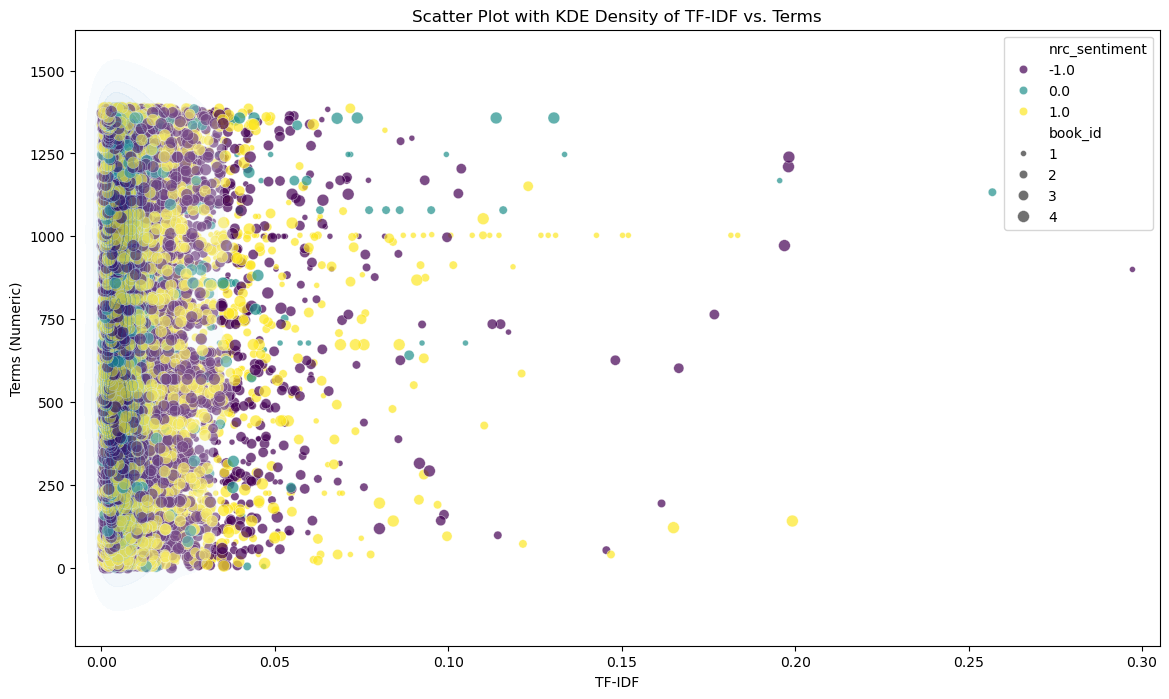

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Prepare data for the plot
bow_sent_plot = BOW_SENT.copy()

# Convert term_str to numeric using LabelEncoder for easy plotting
le = LabelEncoder()
bow_sent_plot['term_str_num'] = le.fit_transform(bow_sent_plot['term_str'])

# Scatter plot with KDE density
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='tfidf', 
    y='term_str_num', 
    size='book_id', 
    hue='nrc_sentiment',  # Change hue to nrc_sentiment
    data=bow_sent_plot, 
    palette='viridis', 
    alpha=0.7
)
sns.kdeplot(
    x='tfidf', 
    y='term_str_num',
    data=bow_sent_plot, 
    cmap='Blues', 
    fill=True, 
    alpha=0.3
)
plt.xlabel('TF-IDF')
plt.ylabel('Terms (Numeric)')
plt.title('Scatter Plot with KDE Density of TF-IDF vs. Terms')
plt.colorbar()
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

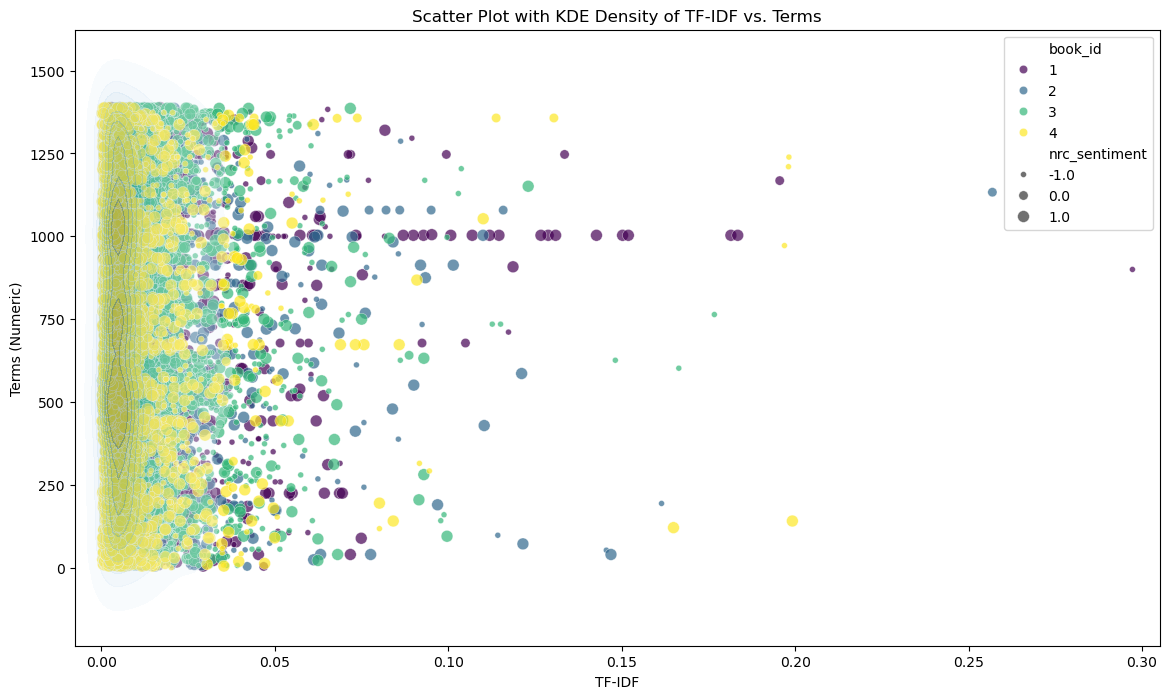

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Prepare data for the plot
bow_sent_plot = BOW_SENT.copy()

# Convert term_str to numeric using LabelEncoder for easy plotting
le = LabelEncoder()
bow_sent_plot['term_str_num'] = le.fit_transform(bow_sent_plot['term_str'])

# Scatter plot with KDE density
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='tfidf', 
    y='term_str_num', 
    size='nrc_sentiment',  # Change size to nrc_sentiment
    hue='book_id',  # Change hue to book_id
    data=bow_sent_plot, 
    palette='viridis', 
    alpha=0.7
)
sns.kdeplot(
    x='tfidf', 
    y='term_str_num',
    data=bow_sent_plot, 
    cmap='Blues', 
    fill=True, 
    alpha=0.3
)
plt.xlabel('TF-IDF')
plt.ylabel('Terms (Numeric)')
plt.title('Scatter Plot with KDE Density of TF-IDF vs. Terms')
plt.colorbar()
plt.show()
